# 04: M2/S1 - Supervised Classification (Token Level)

**Cíl:** Natrénovat klasifikátory (LogReg, SVM, XGBoost) na detekci subjektivity (LJMPNIK).

**Scénáře:**
* **S1a - Baseline (Imbalanced):** Trénink na Gold datech (všechny L0).
* **S1b - Gold Balanced:** Trénink na Gold datech s undersamplingem L0 (1:1).
* **S1d - Noisy Train:** Trénink na Silver datech (větší, ale šum), test na Gold.
* **S1e - Hybrid:** Trénink na mixu Gold + Silver.
* **S1c - Bootstrap:** Test stability S1b (na konci notebooku).

## 1. Setup & Imports

In [9]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import logging
from pathlib import Path
import os
from itables import show

from sklearn.metrics import classification_report


# Auto-reload modules for development
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add src to path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

# Vlastní moduly
import config
import data_splitting
import models
import evaluation
import visualization

# Logging setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Nastavení vizualizace
visualization.setup_style()

print(f"✅ Setup complete. Data dir: {config.DATA_DIR}")

2026-02-05 12:33:09,886 - INFO - 🎨 Visualization style set: whitegrid


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Setup complete. Data dir: C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data


## 2. Data Check (Přehled scénářů)
Než spustíme trénink, podíváme se, kolik máme dat v jednotlivých scénářích.

In [2]:
SCENARIOS_TO_CHECK = ['baseline', 'noisy_train', 'hybrid']

print(f"{'='*80}")
print(f"📊 DATA CHECK REPORT (M2 - Supervised)")
print(f"{'='*80}")

for scenario in SCENARIOS_TO_CHECK:
    print(f"\n🔹 SCÉNÁŘ: {scenario.upper()}")
    try:
        data = data_splitting.get_train_val_test_splits(
            scenario=scenario,
            level='token',
            filter_type='aggressive', # Pro supervised dáváme aggressive filtr (jen podstatná jména atd.)
            random_state=42
        )
        
        # Pomocná funkce pro výpis
        def print_stats(name, y):
            n_l0, n_l1 = np.sum(y == 0), np.sum(y == 1)
            ratio = n_l0 / n_l1 if n_l1 > 0 else 0
            print(f"   {name:<6} | Total: {len(y):<5} | L0 (Neutral): {n_l0:<4} | L1 (Bias): {n_l1:<4} | Ratio: {ratio:.1f}:1")

        print_stats("TRAIN", data['y_train'])
        print_stats("VAL",   data['y_val'])
        print_stats("TEST",  data['y_test'])
        
    except Exception as e:
        print(f"   ❌ Chyba při načítání: {e}")

2026-02-05 12:23:48,567 - INFO - 📊 Preparing scenario: baseline (token level, aggressive filter)


📊 DATA CHECK REPORT (M2 - Supervised)

🔹 SCÉNÁŘ: BASELINE


2026-02-05 12:23:49,133 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-05 12:23:51,925 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-05 12:23:53,188 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-05 12:23:53,205 - INFO - ✅ Document-level split completed:
2026-02-05 12:23:53,206 - INFO -    Train: 376 docs, 2585 samples
2026-02-05 12:23:53,207 - INFO -    Val:   41 docs, 270 samples
2026-02-05 12:23:53,208 - INFO -    Test:  103 docs, 741 samples
2026-02-05 12:23:53,210 - INFO -    ✓ No document leakage detected between splits
2026-02-05 12:23:53,211 - INFO - ✅ Scenario data prepared:
2026-02-05 12:23:53,213 - INFO -    Train: 2585 samples (L0: 900, L1: 1685)
2026-02-05 12:23:53,215 - INFO -    Val:   270 samples (L0: 96, L1: 174)
2026-02-05 12:23:53,216 - INFO -    Test:  741 samples (L0

   TRAIN  | Total: 2585  | L0 (Neutral): 2409 | L1 (Bias): 176  | Ratio: 13.7:1
   VAL    | Total: 270   | L0 (Neutral): 250  | L1 (Bias): 20   | Ratio: 12.5:1
   TEST   | Total: 741   | L0 (Neutral): 695  | L1 (Bias): 46   | Ratio: 15.1:1

🔹 SCÉNÁŘ: NOISY_TRAIN


2026-02-05 12:23:53,814 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-05 12:23:56,220 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-05 12:23:56,298 - INFO - Splitting 1903 documents: 1 test, 285 val, 1617 train
2026-02-05 12:23:56,313 - INFO - ✅ Document-level split completed:
2026-02-05 12:23:56,315 - INFO -    Train: 1617 docs, 15232 samples
2026-02-05 12:23:56,317 - INFO -    Val:   284 docs, 2697 samples
2026-02-05 12:23:56,319 - INFO -    Test:  2 docs, 19 samples
2026-02-05 12:23:56,322 - INFO -    ✓ No document leakage detected between splits
2026-02-05 12:23:56,335 - INFO -    Balanced via undersampling: 7099 + 8133 → 14198
2026-02-05 12:23:56,347 - INFO - ✅ Scenario data prepared:
2026-02-05 12:23:56,348 - INFO -    Train: 14198 samples (L0: 7099, L1: 7099)
2026-02-05 12:23:56,351 - INFO -    Val:   

   TRAIN  | Total: 14198 | L0 (Neutral): 13556 | L1 (Bias): 642  | Ratio: 21.1:1
   VAL    | Total: 2697  | L0 (Neutral): 2567 | L1 (Bias): 130  | Ratio: 19.7:1
   TEST   | Total: 3596  | L0 (Neutral): 3354 | L1 (Bias): 242  | Ratio: 13.9:1

🔹 SCÉNÁŘ: HYBRID


2026-02-05 12:23:56,947 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-05 12:23:59,155 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-05 12:23:59,377 - INFO - Splitting 1472 documents: 294 test, 117 val, 1061 train
2026-02-05 12:23:59,412 - INFO - ✅ Document-level split completed:
2026-02-05 12:23:59,416 - INFO -    Train: 1062 docs, 9463 samples
2026-02-05 12:23:59,419 - INFO -    Val:   117 docs, 1067 samples
2026-02-05 12:23:59,421 - INFO -    Test:  293 docs, 2661 samples
2026-02-05 12:23:59,426 - INFO -    ✓ No document leakage detected between splits
2026-02-05 12:23:59,449 - INFO -    Balanced via undersampling: 900 + 8563 → 1800
2026-02-05 12:23:59,454 - INFO - ✅ Scenario data prepared:
2026-02-05 12:23:59,458 - INFO -    Train: 1800 samples (L0: 900, L1: 900)
2026-02-05 12:23:59,460 - INFO -    Val:   

   TRAIN  | Total: 1800  | L0 (Neutral): 1706 | L1 (Bias): 94   | Ratio: 18.1:1
   VAL    | Total: 1067  | L0 (Neutral): 977  | L1 (Bias): 90   | Ratio: 10.9:1
   TEST   | Total: 2661  | L0 (Neutral): 2433 | L1 (Bias): 228  | Ratio: 10.7:1


## 3. Experiment Loop (S1a, S1b, S1d, S1e)
Postupně natrénujeme modely pro všechny definované scénáře.

**Modely:**
* **LogReg:** Logistic Regression (Baseline)
* **SVM (Lin):** Linear SVM (Rychlé, dobré pro text)
* **SVM (RBF):** Kernel SVM (Zachytí nelinearity)
* **XGBoost:** Gradient Boosting (Pokud je dostupný)

In [3]:
# Definice cesty pro ukládání výsledků
RESULTS_PATH = config.RESULTS_DIR / "M2_S1_experiment_results_v3.csv"

# Definice experimentů
EXPERIMENTS = [
    # S1a: Baseline Imbalanced (Všechna data)
    {'id': 'S1a', 'name': 'Baseline (Imbalanced)', 'scenario': 'baseline', 'balance_train': False},
    
    # S1b: Baseline Balanced (Undersampling L0)
    {'id': 'S1b', 'name': 'Baseline (Balanced)',   'scenario': 'baseline', 'balance_train': True},
    
    # S1d: Noisy Train (Silver -> Gold)
    {'id': 'S1d', 'name': 'Noisy Train (Silver)',  'scenario': 'noisy_train', 'balance_train': False}, 
    
    # S1e: Hybrid (Gold + Silver)
    {'id': 'S1e', 'name': 'Hybrid (Gold+Silver)',  'scenario': 'hybrid', 'balance_train': False},      
]

# Modely k otestování
# MODELS_TO_TEST = ["LogReg", "SVM (RBF)", "XGBoost", "Dummy", "SVM (Lin)", "NaiveBayes", "RandForest"]
MODELS_TO_TEST = ['LogReg', 'SVM (Lin)', 'SVM (RBF)']

if models.XGBOOST_AVAILABLE:
    MODELS_TO_TEST.append('XGBoost')

In [4]:
# %%script false          # Buňka je přeskočena, ať netrénujeme pokaždé. 

# Ukládání výsledků
results = []
best_f1 = 0.0
best_run = None

print(f"🚀 STARTING EXPERIMENTS ({len(EXPERIMENTS)} scenarios x {len(MODELS_TO_TEST)} models)...")
print(f"💾 Results will be saved continuously to: {RESULTS_PATH}")

print(f"💾 Results will be saved to: {RESULTS_PATH}")

for exp in EXPERIMENTS:
    print(f"\n{'='*60}")
    print(f"🧪 SCENARIO: {exp['id']} - {exp['name']}")
    print(f"{'='*60}")
    
    # 1. Načtení dat
    data = data_splitting.get_train_val_test_splits(
        scenario=exp['scenario'], level='token', filter_type='aggressive', random_state=42
    )
    X_train, y_train = data['X_train'], data['y_train']
    X_val, y_val = data['X_val'], data['y_val']
    X_test, y_test = data['X_test'], data['y_test']
    
    # 2. Manuální Undersampling pro S1b
    if exp['balance_train'] and exp['scenario'] == 'baseline':
        idx_l0 = np.where(y_train == 0)[0]
        idx_l1 = np.where(y_train == 1)[0]
        np.random.seed(42)
        idx_l0_down = np.random.choice(idx_l0, size=len(idx_l1), replace=False)
        idx_balanced = np.concatenate([idx_l0_down, idx_l1])
        np.random.shuffle(idx_balanced)
        X_train, y_train = X_train[idx_balanced], y_train[idx_balanced]

    # 3. Trénink
    for model_name in MODELS_TO_TEST:
        print(f"   ⚙️ Training {model_name}...")
        try:
            clf = models.get_supervised_model(model_name, random_state=42)
            clf.fit(X_train, y_train)
            
            # --- ZÍSKÁNÍ SKÓRE PRO VŠECHNY SADY ---
            if hasattr(clf, "predict_proba"):
                s_train = clf.predict_proba(X_train)[:, 1]
                s_val = clf.predict_proba(X_val)[:, 1]
                s_test = clf.predict_proba(X_test)[:, 1]
            else:
                s_train = clf.decision_function(X_train)
                s_val = clf.decision_function(X_val)
                s_test = clf.decision_function(X_test)
            
            # --- OPTIMALIZACE PRAHU (NA VAL) ---
            threshold, _ = evaluation.find_optimal_threshold(y_val, s_val, metric='f1')
            
            # --- APLIKACE PRAHU ---
            p_train = (s_train > threshold).astype(int)
            p_val = (s_val > threshold).astype(int)
            p_test = (s_test > threshold).astype(int)
            
            # --- VÝPOČET METRIK PRO VŠECHNY SADY ---
            m_train = evaluation.calculate_metrics(y_train, p_train, s_train)
            m_val = evaluation.calculate_metrics(y_val, p_val, s_val)
            m_test = evaluation.calculate_metrics(y_test, p_test, s_test)
            
            # Log Result (Ukládáme vše s prefixy)
            # Log Result
            res = {
                'id': exp['id'],
                'scenario': exp['scenario'],       
                'scenario_name': exp['name'],     
                'model': model_name,
                'threshold': threshold,
                'balance_train': exp['balance_train'], # Uložíme si info, jestli jsme balancovali
                
                # Train Metrics
                'train_f1': m_train['f1'], 'train_auprc': m_train['avg_precision'], 
                'train_roc_auc': m_train['roc_auc'], 'train_prec': m_train['precision'], 'train_rec': m_train['recall'],
                
                # Val Metrics
                'val_f1': m_val['f1'], 'val_auprc': m_val['avg_precision'],
                'val_roc_auc': m_val['roc_auc'], 'val_prec': m_val['precision'], 'val_rec': m_val['recall'],
                
                # Test Metrics
                'test_f1': m_test['f1'], 'test_auprc': m_test['avg_precision'],
                'test_roc_auc': m_test['roc_auc'], 'test_prec': m_test['precision'], 'test_rec': m_test['recall'],
            }
            results.append(res)
            
            # Průběžné uložení
            pd.DataFrame(results).to_csv(RESULTS_PATH, index=False)

            if m_test['f1'] > best_f1:
                best_f1 = m_test['f1']
                best_run = {'info': res, 'model': clf, 'data': data, 'scores_test': s_test, 'y_test': y_test}
            
            print(f"      Done. F1 [T:{m_train['f1']:.2f} | V:{m_val['f1']:.2f} | Test:{m_test['f1']:.2f}]")
            
        except Exception as e:
            print(f"      ❌ Error: {e}")

print(f"\n✅ All experiments finished. Saved to {RESULTS_PATH}")

2026-02-05 12:24:01,170 - INFO - 📊 Preparing scenario: baseline (token level, aggressive filter)


🚀 STARTING EXPERIMENTS (4 scenarios x 4 models)...
💾 Results will be saved continuously to: C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\results\M2_S1_experiment_results_v3.csv
💾 Results will be saved to: C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\results\M2_S1_experiment_results_v3.csv

🧪 SCENARIO: S1a - Baseline (Imbalanced)


2026-02-05 12:24:01,717 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-05 12:24:04,008 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-05 12:24:04,070 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-05 12:24:04,078 - INFO - ✅ Document-level split completed:
2026-02-05 12:24:04,079 - INFO -    Train: 376 docs, 2585 samples
2026-02-05 12:24:04,080 - INFO -    Val:   41 docs, 270 samples
2026-02-05 12:24:04,081 - INFO -    Test:  103 docs, 741 samples
2026-02-05 12:24:04,084 - INFO -    ✓ No document leakage detected between splits
2026-02-05 12:24:04,085 - INFO - ✅ Scenario data prepared:
2026-02-05 12:24:04,087 - INFO -    Train: 2585 samples (L0: 900, L1: 1685)
2026-02-05 12:24:04,090 - INFO -    Val:   270 samples (L0: 96, L1: 174)
2026-02-05 12:24:04,093 - INFO -    Test:  741 samples (L0

   ⚙️ Training LogReg...
      Done. F1 [T:0.93 | V:0.70 | Test:0.62]
   ⚙️ Training SVM (Lin)...
      Done. F1 [T:0.98 | V:0.60 | Test:0.53]
   ⚙️ Training SVM (RBF)...
      Done. F1 [T:0.89 | V:0.61 | Test:0.56]
   ⚙️ Training XGBoost...


2026-02-05 12:24:21,377 - INFO - 📊 Preparing scenario: baseline (token level, aggressive filter)


      Done. F1 [T:1.00 | V:0.59 | Test:0.58]

🧪 SCENARIO: S1b - Baseline (Balanced)


2026-02-05 12:24:21,817 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-05 12:24:23,891 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-05 12:24:23,945 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-05 12:24:23,953 - INFO - ✅ Document-level split completed:
2026-02-05 12:24:23,954 - INFO -    Train: 376 docs, 2585 samples
2026-02-05 12:24:23,955 - INFO -    Val:   41 docs, 270 samples
2026-02-05 12:24:23,956 - INFO -    Test:  103 docs, 741 samples
2026-02-05 12:24:23,958 - INFO -    ✓ No document leakage detected between splits
2026-02-05 12:24:23,960 - INFO - ✅ Scenario data prepared:
2026-02-05 12:24:23,962 - INFO -    Train: 2585 samples (L0: 900, L1: 1685)
2026-02-05 12:24:23,964 - INFO -    Val:   270 samples (L0: 96, L1: 174)
2026-02-05 12:24:23,966 - INFO -    Test:  741 samples (L0

   ⚙️ Training LogReg...
      Done. F1 [T:0.83 | V:0.59 | Test:0.57]
   ⚙️ Training SVM (Lin)...
      Done. F1 [T:0.70 | V:0.55 | Test:0.53]
   ⚙️ Training SVM (RBF)...
      Done. F1 [T:0.92 | V:0.53 | Test:0.61]
   ⚙️ Training XGBoost...


2026-02-05 12:24:25,925 - INFO - 📊 Preparing scenario: noisy_train (token level, aggressive filter)


      Done. F1 [T:1.00 | V:0.46 | Test:0.44]

🧪 SCENARIO: S1d - Noisy Train (Silver)


2026-02-05 12:24:26,348 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-05 12:24:28,441 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-05 12:24:28,522 - INFO - Splitting 1903 documents: 1 test, 285 val, 1617 train
2026-02-05 12:24:28,538 - INFO - ✅ Document-level split completed:
2026-02-05 12:24:28,539 - INFO -    Train: 1617 docs, 15232 samples
2026-02-05 12:24:28,540 - INFO -    Val:   284 docs, 2697 samples
2026-02-05 12:24:28,541 - INFO -    Test:  2 docs, 19 samples
2026-02-05 12:24:28,546 - INFO -    ✓ No document leakage detected between splits
2026-02-05 12:24:28,559 - INFO -    Balanced via undersampling: 7099 + 8133 → 14198
2026-02-05 12:24:28,572 - INFO - ✅ Scenario data prepared:
2026-02-05 12:24:28,579 - INFO -    Train: 14198 samples (L0: 7099, L1: 7099)
2026-02-05 12:24:28,584 - INFO -    Val:   

   ⚙️ Training LogReg...
      Done. F1 [T:0.79 | V:0.69 | Test:0.55]
   ⚙️ Training SVM (Lin)...
      Done. F1 [T:0.79 | V:0.62 | Test:0.51]
   ⚙️ Training SVM (RBF)...
      Done. F1 [T:0.88 | V:0.72 | Test:0.57]
   ⚙️ Training XGBoost...


2026-02-05 12:31:01,202 - INFO - 📊 Preparing scenario: hybrid (token level, aggressive filter)


      Done. F1 [T:1.00 | V:0.65 | Test:0.57]

🧪 SCENARIO: S1e - Hybrid (Gold+Silver)


2026-02-05 12:31:01,876 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-05 12:31:04,204 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-05 12:31:04,293 - INFO - Splitting 1472 documents: 294 test, 117 val, 1061 train
2026-02-05 12:31:04,311 - INFO - ✅ Document-level split completed:
2026-02-05 12:31:04,313 - INFO -    Train: 1062 docs, 9463 samples
2026-02-05 12:31:04,314 - INFO -    Val:   117 docs, 1067 samples
2026-02-05 12:31:04,315 - INFO -    Test:  293 docs, 2661 samples
2026-02-05 12:31:04,318 - INFO -    ✓ No document leakage detected between splits
2026-02-05 12:31:04,326 - INFO -    Balanced via undersampling: 900 + 8563 → 1800
2026-02-05 12:31:04,329 - INFO - ✅ Scenario data prepared:
2026-02-05 12:31:04,332 - INFO -    Train: 1800 samples (L0: 900, L1: 900)
2026-02-05 12:31:04,334 - INFO -    Val:   

   ⚙️ Training LogReg...
      Done. F1 [T:0.96 | V:0.59 | Test:0.54]
   ⚙️ Training SVM (Lin)...
      Done. F1 [T:1.00 | V:0.54 | Test:0.52]
   ⚙️ Training SVM (RBF)...
      Done. F1 [T:0.81 | V:0.60 | Test:0.55]
   ⚙️ Training XGBoost...
      Done. F1 [T:1.00 | V:0.47 | Test:0.47]

✅ All experiments finished. Saved to C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\results\M2_S1_experiment_results_v3.csv


## 4. Results Overview
Srovnání všech modelů a scénářů.

In [5]:
# RESULTS_PATH = config.RESULTS_DIR / "M2_S1_experiment_results_v3.csv"     # možno upravit pro načtení jiného souboru

if RESULTS_PATH.exists():
    df_results = pd.read_csv(RESULTS_PATH)
    print(f"📂 Loaded results from: {RESULTS_PATH}")
    print(f"   Počet záznamů: {len(df_results)}")
else:
    print("⚠️ Výsledkový soubor neexistuje.")
    # Fallback, pokud bys to pustil hned po tréninku bez uložení (což se díky úpravě výše nestane)
    if 'results' in locals() and results:
        df_results = pd.DataFrame(results)

# 2. Pivot Table: Srovnání F1 Skóre
if not df_results.empty:
    pivot_f1 = df_results.pivot_table(
        values='test_f1', 
        index='scenario', 
        columns='model', 
        aggfunc='max'
    )

    print("\n📊 SROVNÁNÍ F1 SKÓRE:")
    display(pivot_f1.style.background_gradient(cmap='Greens', axis=None).format("{:.4f}"))

    # 3. Pivot Table: Srovnání AUPRC
    pivot_auprc = df_results.pivot_table(
        values='test_auprc', 
        index='scenario', 
        columns='model', 
        aggfunc='max'
    )

    print("\n📊 SROVNÁNÍ AUPRC:")
    display(pivot_auprc.style.background_gradient(cmap='Blues', axis=None).format("{:.4f}"))

📂 Loaded results from: C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\results\M2_S1_experiment_results_v3.csv
   Počet záznamů: 16

📊 SROVNÁNÍ F1 SKÓRE:


model,LogReg,SVM (Lin),SVM (RBF),XGBoost
scenario,,,,
baseline,0.6222,0.5287,0.6087,0.5789
hybrid,0.5374,0.5161,0.5461,0.4718
noisy_train,0.5497,0.5089,0.5707,0.5695



📊 SROVNÁNÍ AUPRC:


model,LogReg,SVM (Lin),SVM (RBF),XGBoost
scenario,,,,
baseline,0.7126,0.6080,0.7074,0.6116
hybrid,0.5323,0.5023,0.5480,0.4690
noisy_train,0.5856,0.5043,0.6367,0.5620


In [6]:
show(df_results)

Loading ITables v2.6.2 from the internet... (need help?)


[autoreload of visualization failed: Traceback (most recent call last):
  File "c:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\venv\Lib\site-packages\IPython\extensions\autoreload.py", line 322, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\venv\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 545, in maybe_reload_module
    new_source_code = f.read()
                      ^^^^^^^^
  File "C:\Users\dobes\Documents\Anaconda Python\Lib\encodings\cp1250.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x83 in position 15109: character maps to <undefined>
]


📊 Generuji 3-way srovnávací grafy (Pastel Design)...
⚙️ Configuration loaded. Device: cpu
📊 Generuji 3-way srovnávací grafy (podle S1a, S1b...)...
💾 Graf uložen: breakdown_3way_S1a_Baseline_Imbalanced_f1.png


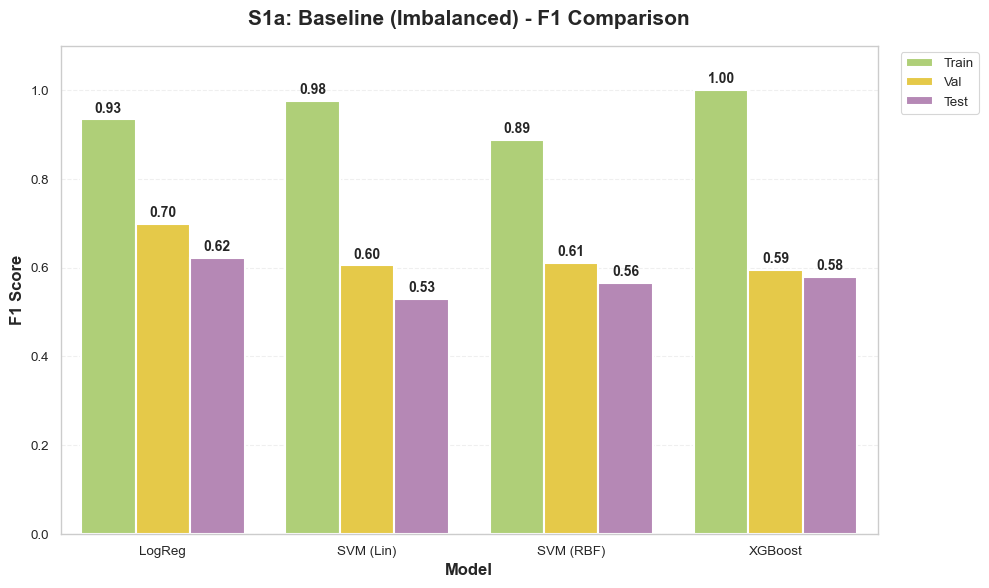

💾 Graf uložen: breakdown_3way_S1b_Baseline_Balanced_f1.png


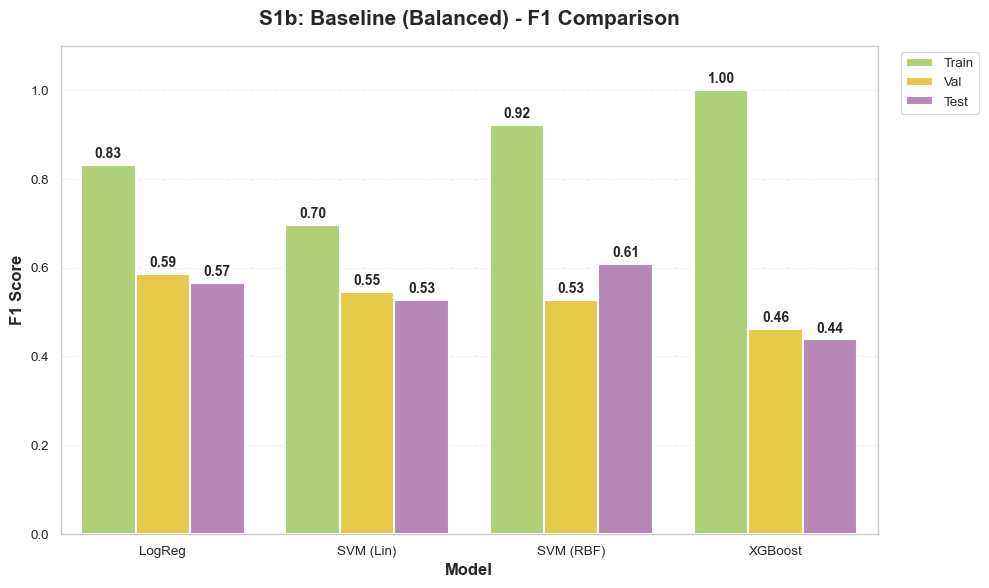

💾 Graf uložen: breakdown_3way_S1d_Noisy_Train_Silver_f1.png


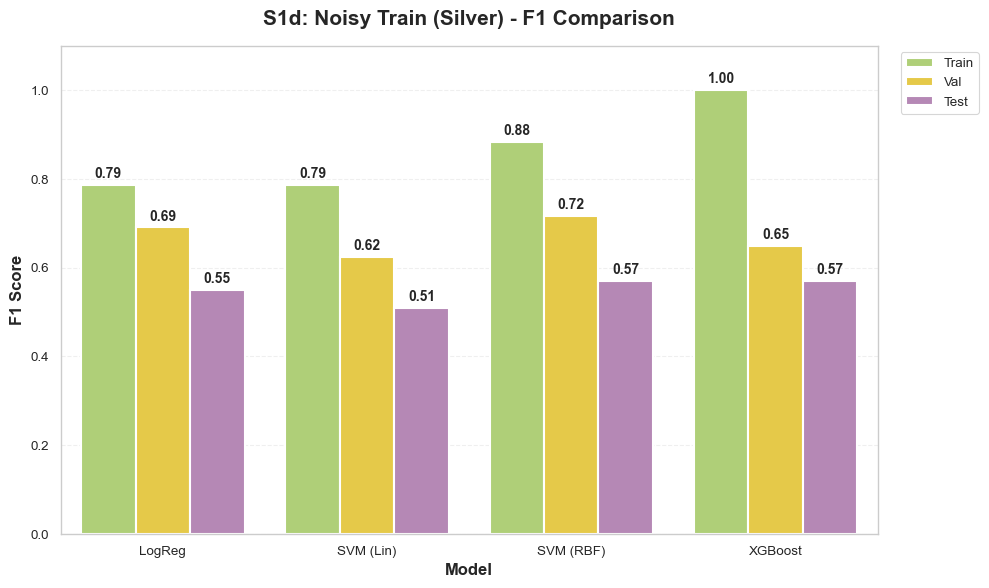

💾 Graf uložen: breakdown_3way_S1e_Hybrid_Gold+Silver_f1.png


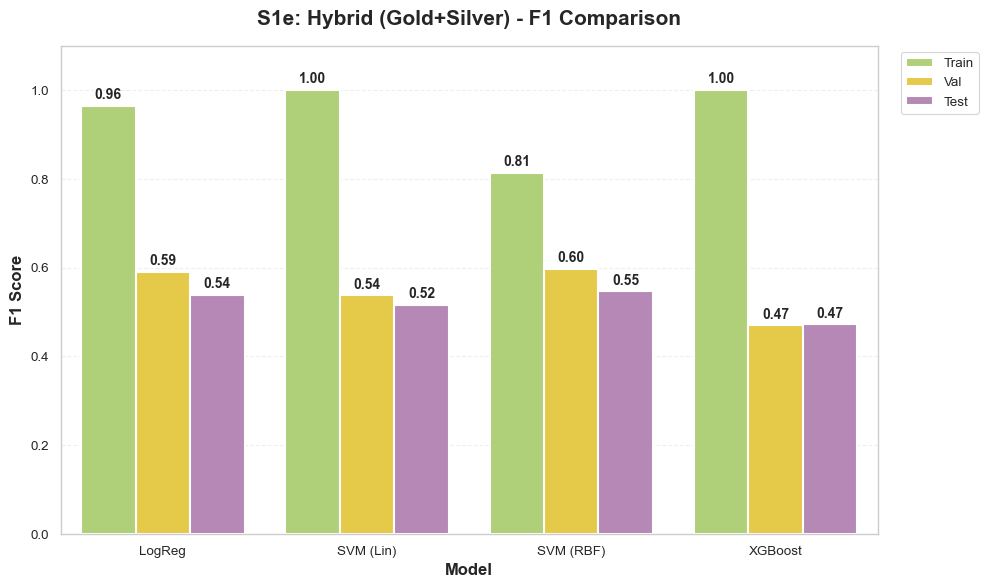

💾 Graf uložen: breakdown_3way_S1a_Baseline_Imbalanced_auprc.png


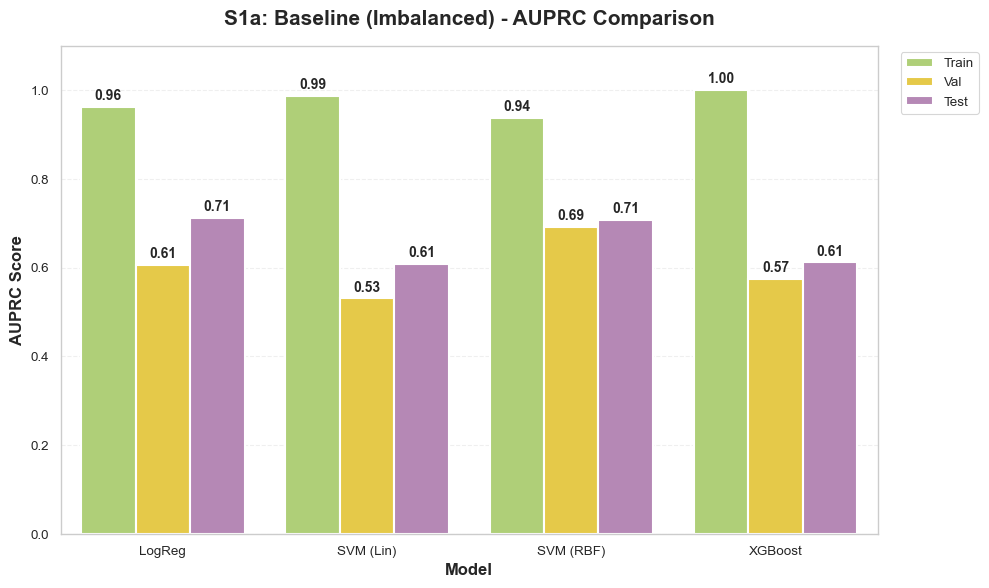

💾 Graf uložen: breakdown_3way_S1b_Baseline_Balanced_auprc.png


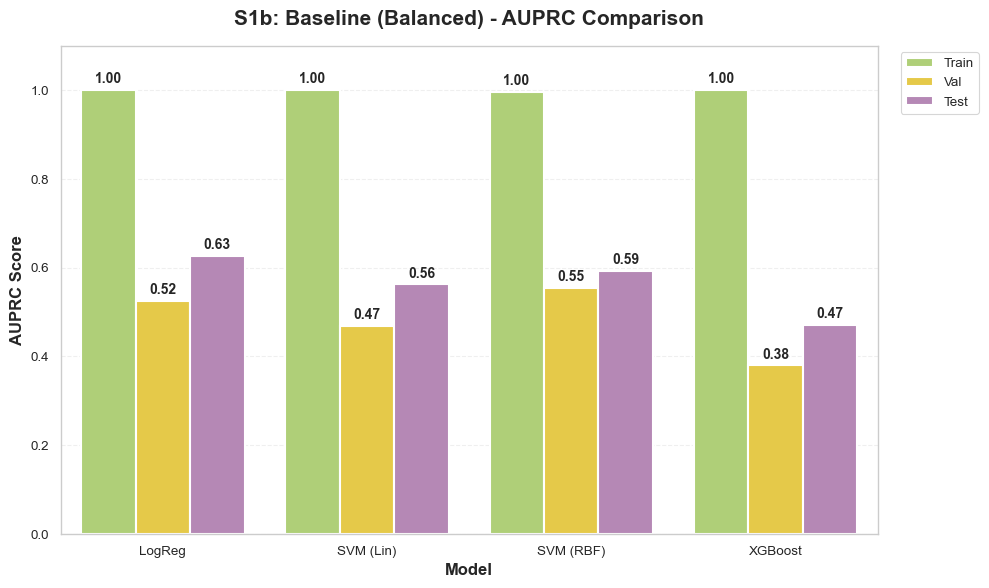

💾 Graf uložen: breakdown_3way_S1d_Noisy_Train_Silver_auprc.png


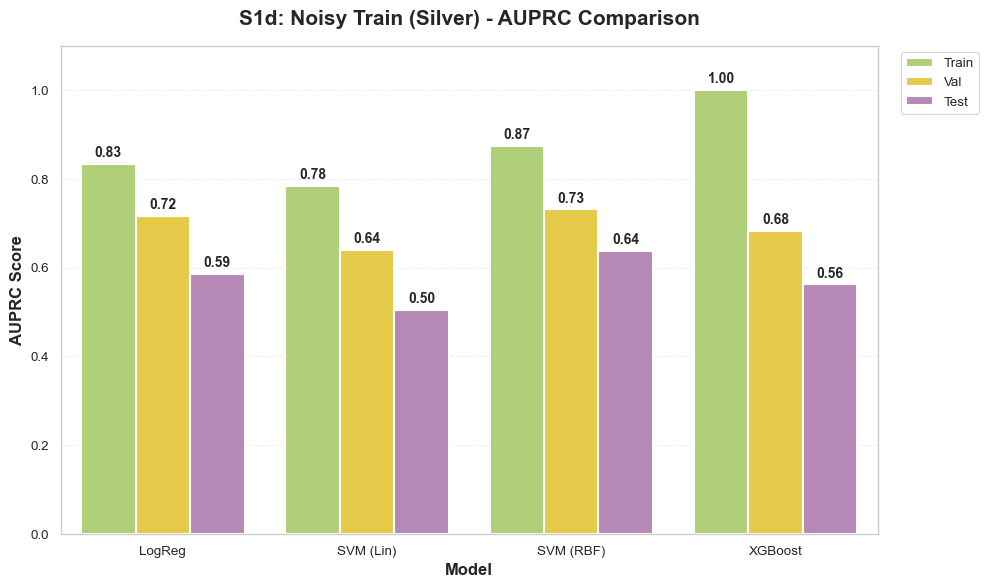

💾 Graf uložen: breakdown_3way_S1e_Hybrid_Gold+Silver_auprc.png


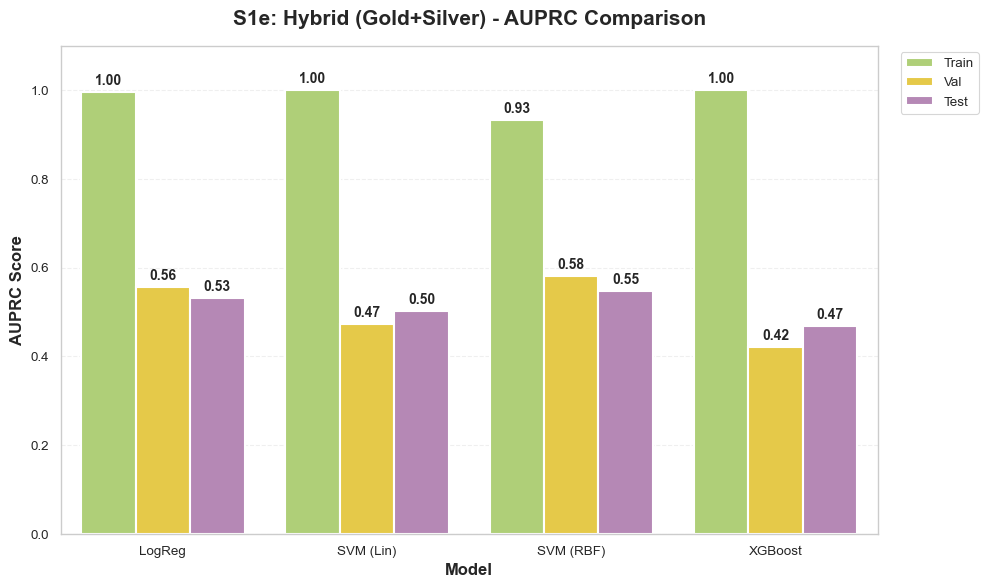

In [13]:
# --- SPUŠTĚNÍ VIZUALIZACE ---
print("📊 Generuji 3-way srovnávací grafy (Pastel Design)...")

# Nezapomeň reloadnout config, pokud jsi ho měnil!
from importlib import reload
reload(config)
reload(visualization)


# --- SPUŠTĚNÍ ---
print("📊 Generuji 3-way srovnávací grafy (podle S1a, S1b...)...")

visualization.plot_three_way_comparison(df_results, metric='f1', save_dir=config.RESULTS_DIR)
visualization.plot_three_way_comparison(df_results, metric='auprc', save_dir=config.RESULTS_DIR)


## 5. Deep Dive: Best Model Analysis
Detailní pohled na vítěze.

In [10]:
# 5. DEEP DIVE: RETRAIN WINNER & DETAILED ANALYSIS

# 1. Načtení výsledků a nalezení vítěze
if RESULTS_PATH.exists():
    df_results = pd.read_csv(RESULTS_PATH)
    
    # Seřadíme podle F1 na Testu (nebo AUPRC, jak chceš)
    best_row = df_results.sort_values('test_f1', ascending=False).iloc[0]
    
    print(f"🏆 WINNER: {best_row['model']} (ID: {best_row['id']})")
    print(f"🌍 Scenario: {best_row['scenario']}")
    print(f"🎯 Threshold:{best_row['threshold']:.4f}")
    print(f"{'-'*30}")
    print(f"📊 F1 Score: {best_row['test_f1']:.4f}")
    print(f"📈 AUPRC:    {best_row['test_auprc']:.4f}")
    print(f"{'='*60}\n")
    
    # 2. Znovunačtení dat pro vítězný scénář
    print(f"🔄 Reloading data for scenario: {best_row['scenario']}...")
    data_best = data_splitting.get_train_val_test_splits(
        scenario=best_row['scenario'],
        level='token',
        filter_type='aggressive',
        random_state=42
    )
    
    X_train_best, y_train_best = data_best['X_train'], data_best['y_train']
    X_val_best, y_val_best     = data_best['X_val'], data_best['y_val']
    X_test_best, y_test_best   = data_best['X_test'], data_best['y_test']

    # 3. Pokud vyhrál S1b (Manual Balanced), musíme znovu provést undersampling
    if best_row['id'] == 'S1b':
        print("   ⚖️ Re-applying Manual Undersampling (1:1) for S1b...")
        idx_l0 = np.where(y_train_best == 0)[0]
        idx_l1 = np.where(y_train_best == 1)[0]
        
        np.random.seed(42) # Stejný seed zaručí stejná data jako v loopu
        idx_l0_down = np.random.choice(idx_l0, size=len(idx_l1), replace=False)
        idx_balanced = np.concatenate([idx_l0_down, idx_l1])
        np.random.shuffle(idx_balanced)
        
        X_train_best, y_train_best = X_train_best[idx_balanced], y_train_best[idx_balanced]
        print(f"   ✅ New Train Size: {X_train_best.shape[0]}")

    # 4. Retrain Model
    print(f"⚙️ Retraining {best_row['model']}...")
    clf = models.get_supervised_model(best_row['model'], random_state=42)
    clf.fit(X_train_best, y_train_best)
    
    # 5. Získání skóre (Train/Val/Test)
    if hasattr(clf, "predict_proba"):
        s_train = clf.predict_proba(X_train_best)[:, 1]
        s_val   = clf.predict_proba(X_val_best)[:, 1]
        s_test  = clf.predict_proba(X_test_best)[:, 1]
    else:
        s_train = clf.decision_function(X_train_best)
        s_val   = clf.decision_function(X_val_best)
        s_test  = clf.decision_function(X_test_best)

    # 6. Aplikace prahu (Bereme ten uložený z CSV, abychom replikovali výsledek)
    threshold = best_row['threshold']
    
    p_train = (s_train > threshold).astype(int)
    p_val   = (s_val > threshold).astype(int)
    p_test  = (s_test > threshold).astype(int)

    # 7. Final Report
    print(f"\n📢 DETAILED CLASSIFICATION REPORT (Threshold: {threshold:.4f})")
    print(f"{'='*60}")
    
    # Funkce pro hezký výpis metrik
    def print_metrics(name, y_true, y_pred, scores):
        m = evaluation.calculate_metrics(y_true, y_pred, scores)
        print(f"\n🔹 {name} SET Results:")
        print(f"   F1 Score:  {m['f1']:.4f}")
        print(f"   AUPRC:     {m['avg_precision']:.4f}")
        print(f"   ROC AUC:   {m['roc_auc']:.4f}")
        print(f"   Precision: {m['precision']:.4f}")
        print(f"   Recall:    {m['recall']:.4f}")
        print("-" * 40)
        print(classification_report(y_true, y_pred, target_names=['Neutral', 'Anomaly'], digits=4))

    print_metrics("TRAIN", y_train_best, p_train, s_train)
    print_metrics("VAL",   y_val_best,   p_val,   s_val)
    print_metrics("TEST",  y_test_best,  p_test,  s_test)
    
    # 8. Příprava proměnných pro vizualizaci v další buňce
    # Simulujeme strukturu 'best_run', aby fungovaly staré vizualizační funkce
    best_run = {
        'info': best_row.to_dict(),
        'model': clf,
        'data': data_best,
        'scores_test': s_test,
        'y_test': y_test_best,
        'threshold': threshold
    }

else:
    print("⚠️ Nemám výsledky. Spusť nejprve trénovací smyčku.")

2026-02-05 12:33:17,906 - INFO - 📊 Preparing scenario: baseline (token level, aggressive filter)


🏆 WINNER: LogReg (ID: S1a)
🌍 Scenario: baseline
🎯 Threshold:0.6755
------------------------------
📊 F1 Score: 0.6222
📈 AUPRC:    0.7126

🔄 Reloading data for scenario: baseline...


2026-02-05 12:33:18,354 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-05 12:33:21,129 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-05 12:33:21,191 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-05 12:33:21,198 - INFO - ✅ Document-level split completed:
2026-02-05 12:33:21,199 - INFO -    Train: 376 docs, 2585 samples
2026-02-05 12:33:21,201 - INFO -    Val:   41 docs, 270 samples
2026-02-05 12:33:21,202 - INFO -    Test:  103 docs, 741 samples
2026-02-05 12:33:21,202 - INFO -    ✓ No document leakage detected between splits
2026-02-05 12:33:21,202 - INFO - ✅ Scenario data prepared:
2026-02-05 12:33:21,202 - INFO -    Train: 2585 samples (L0: 900, L1: 1685)
2026-02-05 12:33:21,202 - INFO -    Val:   270 samples (L0: 96, L1: 174)
2026-02-05 12:33:21,202 - INFO -    Test:  741 samples (L0

⚙️ Retraining LogReg...

📢 DETAILED CLASSIFICATION REPORT (Threshold: 0.6755)

🔹 TRAIN SET Results:
   F1 Score:  0.9337
   AUPRC:     0.9626
   ROC AUC:   0.9981
   Precision: 0.8756
   Recall:    1.0000
----------------------------------------
              precision    recall  f1-score   support

     Neutral     1.0000    0.9896    0.9948      2409
     Anomaly     0.8756    1.0000    0.9337       176

    accuracy                         0.9903      2585
   macro avg     0.9378    0.9948    0.9642      2585
weighted avg     0.9915    0.9903    0.9906      2585


🔹 VAL SET Results:
   F1 Score:  0.6977
   AUPRC:     0.6054
   ROC AUC:   0.9310
   Precision: 0.6522
   Recall:    0.7500
----------------------------------------
              precision    recall  f1-score   support

     Neutral     0.9798    0.9680    0.9738       250
     Anomaly     0.6522    0.7500    0.6977        20

    accuracy                         0.9519       270
   macro avg     0.8160    0.8590    0.8358

📊 Vizualizace pro model: LogReg (Baseline (Imbalanced))


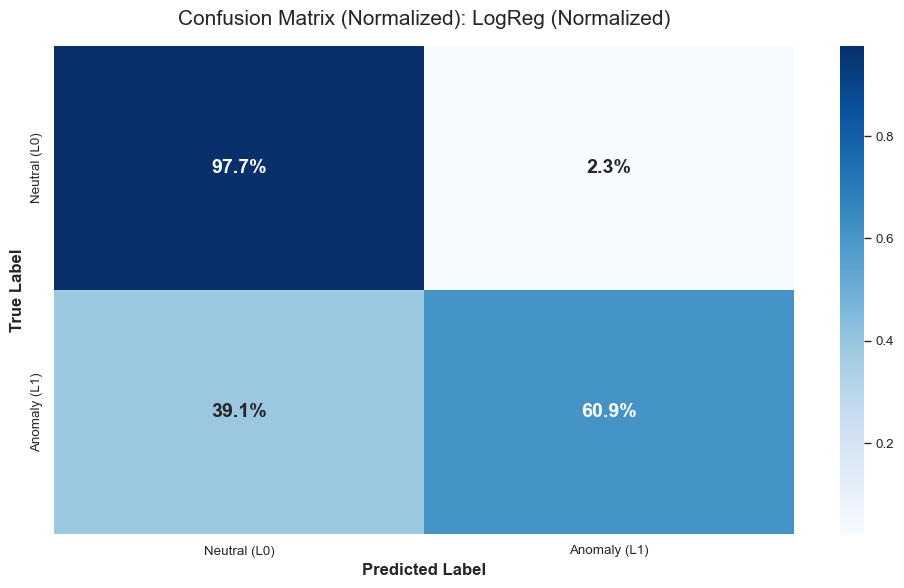

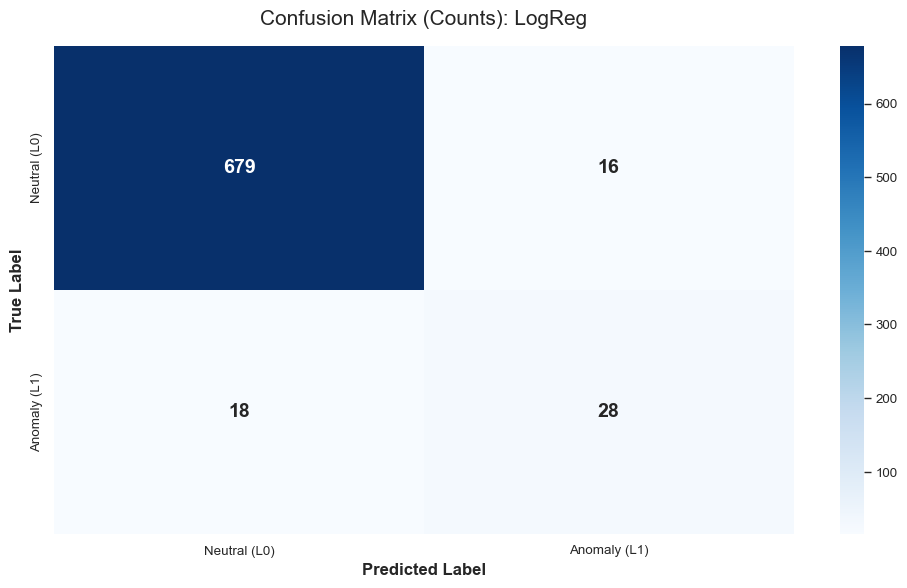

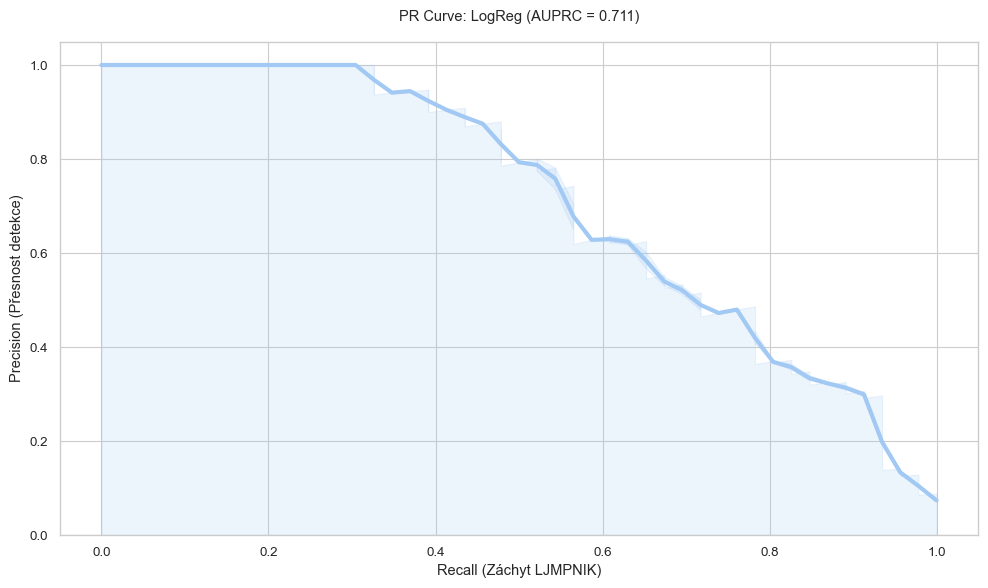

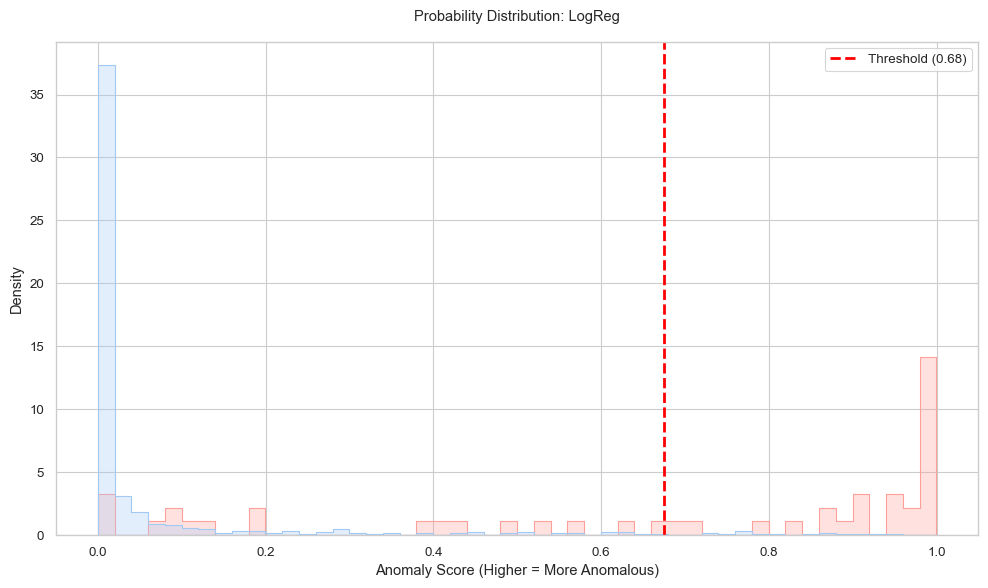

In [ ]:
# =============================================================================
# 5b. DEEP DIVE VIZUALIZACE (Confusion Matrix, PR Curve, Hist)
# =============================================================================

# 1. Vytáhneme si metadata z best_run (TOTO CHYBĚLO)
info = best_run['info']

print(f"📊 Vizualizace pro model: {info['model']} ({info.get('scenario_name', info['scenario'])})")

# Přepočítáme y_pred pro jistotu podle prahu
y_pred = (best_run['scores_test'] > info['threshold']).astype(int)

# 2. Confusion Matrix (Normalizovaná - procenta)
visualization.plot_confusion_matrix_heatmap(
    best_run['y_test'], 
    y_pred, 
    normalize=True,
    title=f"Confusion Matrix (Normalized): {info['model']}"
)

# 3. Confusion Matrix (Absolutní počty - pro kontrolu vzorků)
visualization.plot_confusion_matrix_heatmap(
    best_run['y_test'], 
    y_pred, 
    normalize=False,
    title=f"Confusion Matrix (Counts): {info['model']}"
)

# 4. PR Curve
visualization.plot_pr_curve(
    best_run['y_test'], 
    best_run['scores_test'],
    title=f"PR Curve: {info['model']}"
)

# 5. Histogram Pravděpodobností
visualization.plot_anomaly_histogram(
    best_run['y_test'],
    best_run['scores_test'],
    threshold=info['threshold'],
    title=f"Probability Distribution: {info['model']}"
)

[autoreload of visualization failed: Traceback (most recent call last):
  File "c:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\venv\Lib\site-packages\IPython\extensions\autoreload.py", line 322, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\venv\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 545, in maybe_reload_module
    new_source_code = f.read()
                      ^^^^^^^^
  File "C:\Users\dobes\Documents\Anaconda Python\Lib\encodings\cp1250.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x83 in position 15109: character maps to <undefined>
]



⚖️ ANALÝZA KALIBRACE:


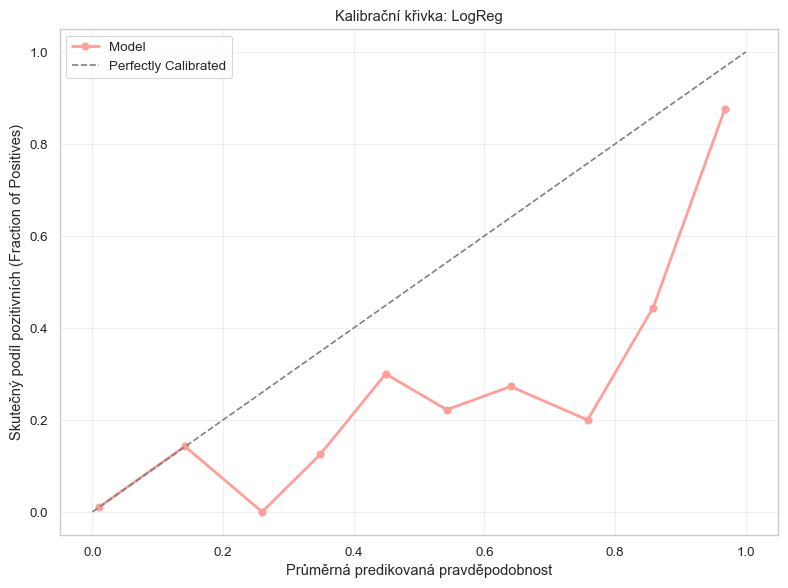

🔍 JAK ČÍST GRAF:
   • Na diagonále = Perfektně kalibrovaný model.
   • Pod diagonálou = Overconfident (Model si věří víc, než by měl).
   • Nad diagonálou = Underconfident (Model je zbytečně opatrný).

🔑 FEATURE IMPORTANCE (Top slova pro LogReg):
⚠️ Pozor: Trénujeme na BERT Embeddings (768 dimenzí).
   Koeficienty nám řeknou, která dimenze vektoru je důležitá,
   ale neřeknou nám přímo konkrétní slova (protože je to dense vector).
   -> Pro interpretaci slov se musíme dívat na Qualitative Analysis (tabulka výše).


In [14]:
# =============================================================================
# 5c. KALIBRACE A DŮLEŽITOST RYSŮ (Feature Importance)
# =============================================================================

# 1. KALIBRACE MODELU
# Ověříme, jak moc model "kecá" ve svých pravděpodobnostech.
print("\n⚖️ ANALÝZA KALIBRACE:")

# Poznámka: Kalibrace vyžaduje pravděpodobnosti [0, 1]. 
# Pokud model vrací jen decision_function (např. SVM bez probability=True), 
# museli bychom to převést sigmoidou. Ale my máme probability=True.

visualization.plot_model_calibration(
    y_true=best_run['y_test'],
    y_probs=best_run['scores_test'],
    title=f"Kalibrační křivka: {info['model']}",
    save_path=config.RESULTS_DIR / f"calibration_{info['id']}_{info['model']}.png"
)

# Krátká interpretace pro tebe do konzole
print("🔍 JAK ČÍST GRAF:")
print("   • Na diagonále = Perfektně kalibrovaný model.")
print("   • Pod diagonálou = Overconfident (Model si věří víc, než by měl).")
print("   • Nad diagonálou = Underconfident (Model je zbytečně opatrný).")

# -----------------------------------------------------------------------------
# 2. FEATURE IMPORTANCE (Co model považuje za bias?)
# -----------------------------------------------------------------------------
# Toto funguje jen pro lineární modely (LogReg, Linear SVM)
model = best_run['model']

if hasattr(model, 'coef_'):
    print(f"\n🔑 FEATURE IMPORTANCE (Top slova pro {info['model']}):")
    
    # Získání koeficientů
    feature_names = np.array(model.feature_names_in_) if hasattr(model, 'feature_names_in_') else None
    
    # Pokud feature names nemáme v modelu, zkusíme je načíst, pokud víme odkud (BERT dimenze nemají jména)
    # Ale pozor! My trénujeme na EMBEDDINGS (768 čísel). 
    # Tady nám feature importance ukáže jen "Dimenze 123 je důležitá", což nám nic neřekne o slovech.
    
    print("⚠️ Pozor: Trénujeme na BERT Embeddings (768 dimenzí).")
    print("   Koeficienty nám řeknou, která dimenze vektoru je důležitá,")
    print("   ale neřeknou nám přímo konkrétní slova (protože je to dense vector).")
    print("   -> Pro interpretaci slov se musíme dívat na Qualitative Analysis (tabulka výše).")
    
else:
    print("\nℹ️ Tento model (např. RBF SVM) nemá přímé koeficienty pro interpretaci rysů.")

#### Embedding Projection

🎨 Počítám projekce pro LogReg (Baseline (Imbalanced))...


2026-02-05 13:37:02,853 - INFO - 1️⃣ Computing PCA...
2026-02-05 13:37:02,916 - INFO - 2️⃣ Computing t-SNE...
2026-02-05 13:37:07,567 - INFO - 3️⃣ Computing UMAP...



🔹 Vizualizace: PCA


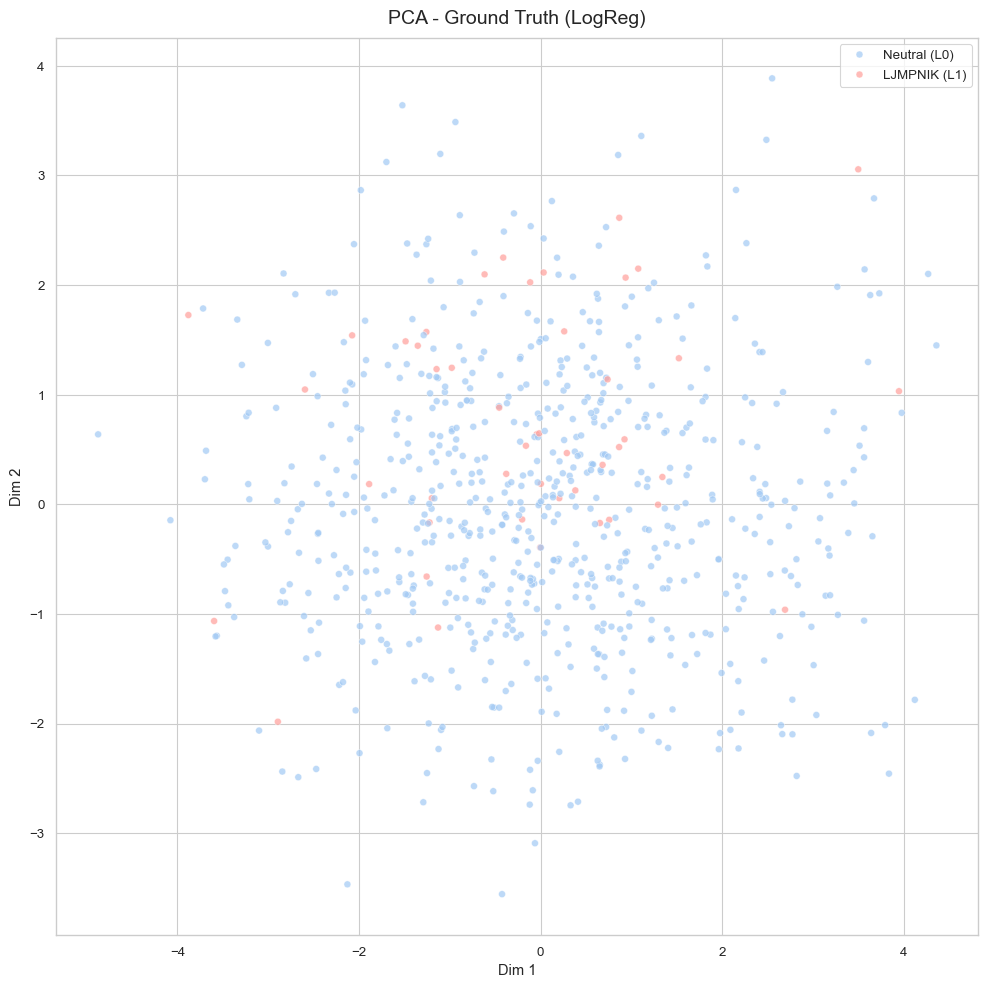

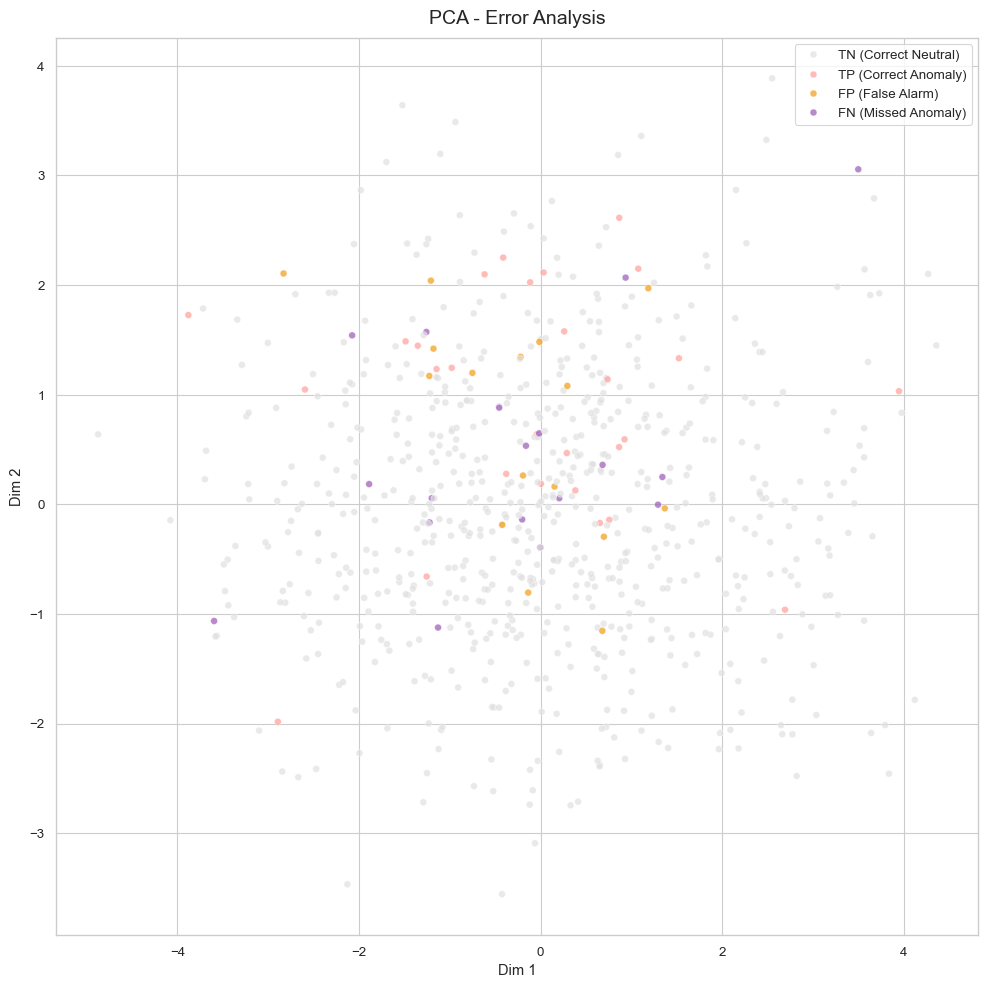


🔹 Vizualizace: t-SNE


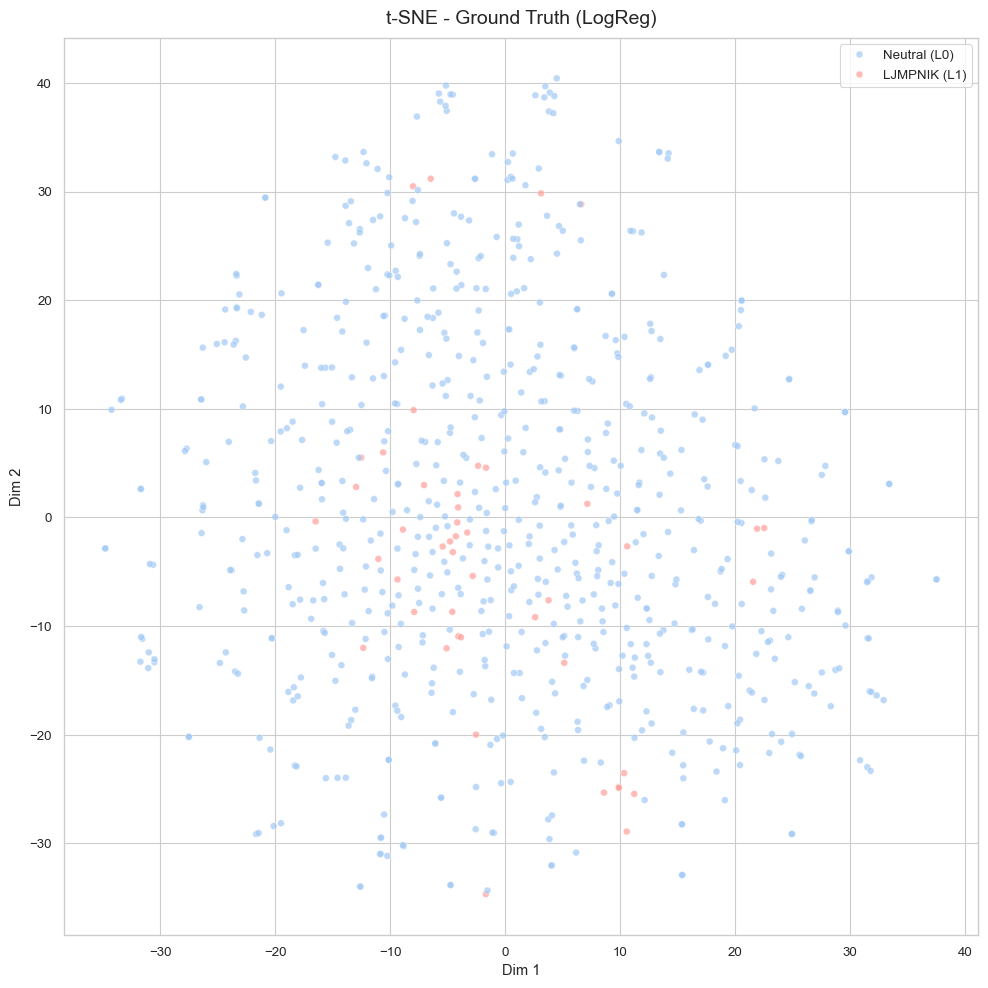

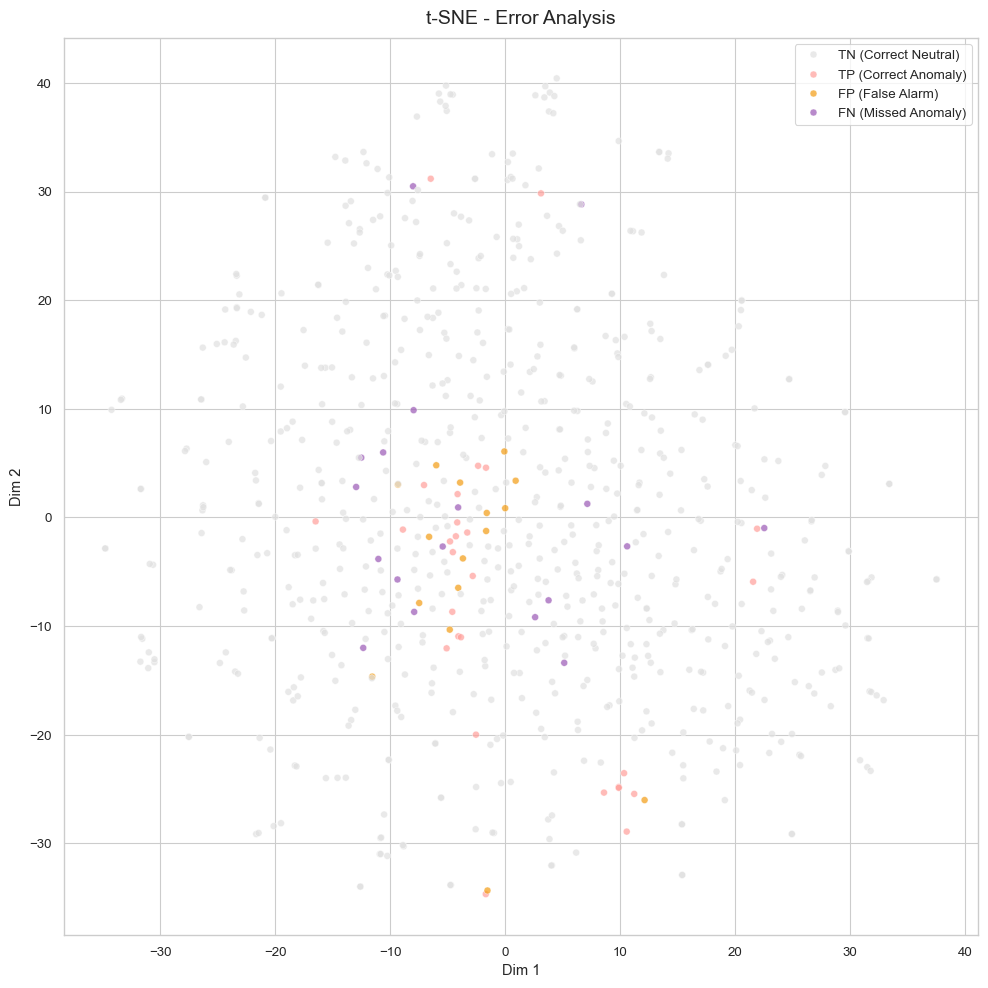


🔹 Vizualizace: UMAP


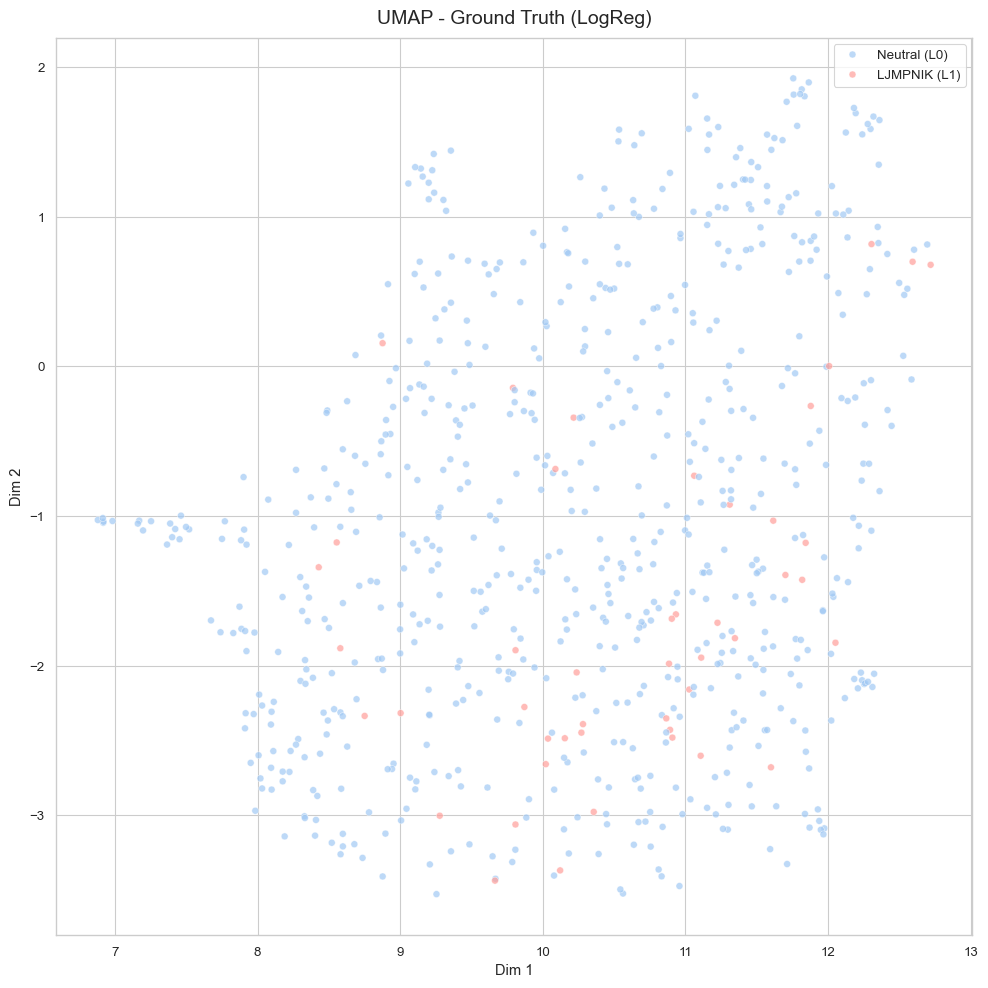

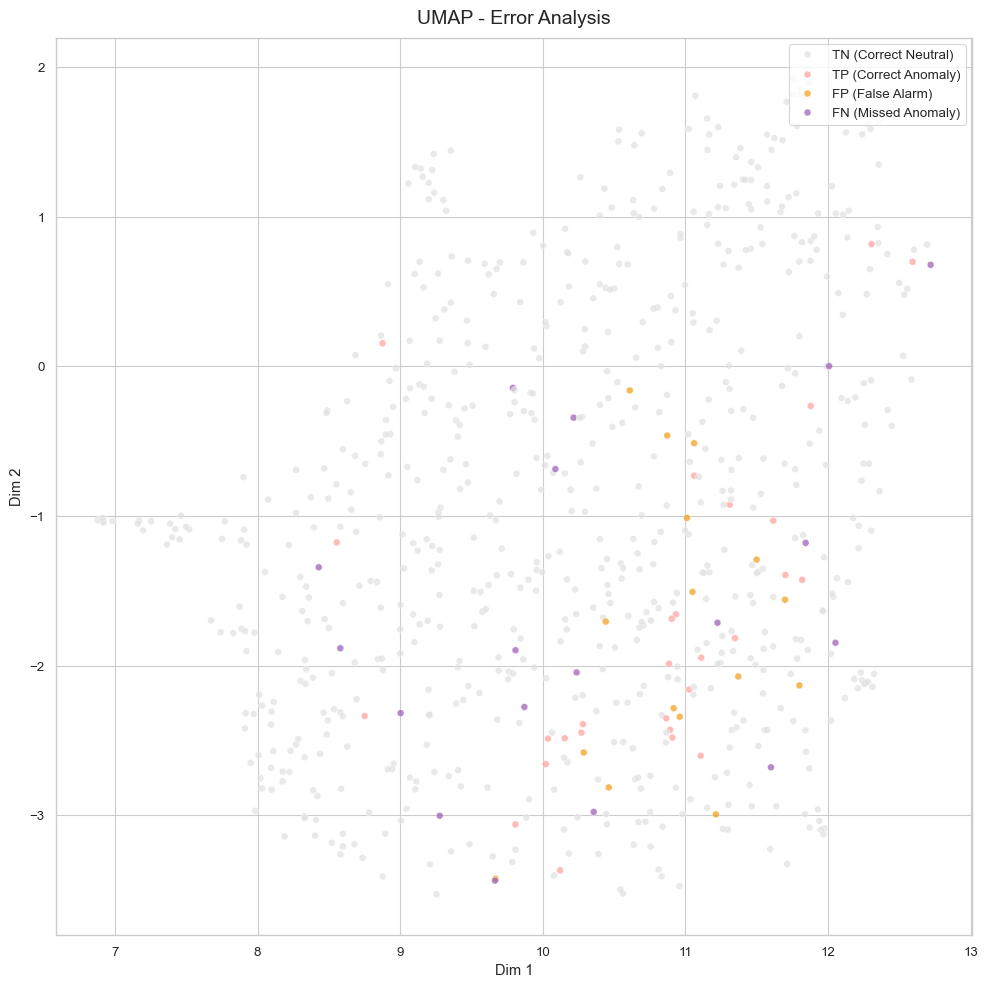


✅ Všechny projekce uloženy.


In [15]:
# PROJEKCE EMBEDDINGŮ (PCA, t-SNE, UMAP)

# Získání názvu modelu a dat z best_run
info = best_run['info']
model_name = info['model']
scenario_name = info.get('scenario_name', info['scenario'])

print(f"🎨 Počítám projekce pro {model_name} ({scenario_name})...")

# 1. Příprava dat
# Bereme X_test přímo z uloženého best_run
X_input = best_run['data']['X_test']
y_test_input = best_run['y_test']
scores_input = best_run['scores_test']

# Dopočítáme y_pred podle prahu (pro Error Analysis)
y_pred_input = (scores_input > info['threshold']).astype(int)

# 2. Výpočet projekcí (funkce sama udělá subsampling, pokud je dat moc)
projections, indices = visualization.compute_projections(
    X_input, 
    methods=['PCA', 't-SNE', 'UMAP'],
    random_state=42
)

# 3. Filtrace labelů (musíme vybrat stejné vzorky, jako vybral subsampling)
y_test_viz = y_test_input[indices]
y_pred_viz = y_pred_input[indices]

# 4. Generování grafů
for method, coords in projections.items():
    print(f"\n🔹 Vizualizace: {method}")
    
    # --- A) Ground Truth (Co to reálně je) ---
    labels_gt = pd.Series(y_test_viz).map({
        0: 'Neutral (L0)', 
        1: 'LJMPNIK (L1)'
    })
    
    visualization.plot_embedding_projection(
        coords=coords, 
        labels=labels_gt,
        palette={
            'Neutral (L0)': config.COLORS['l0'], 
            'LJMPNIK (L1)': config.COLORS['l1']
        },
        title=f"{method} - Ground Truth ({model_name})",
        hue_order=['Neutral (L0)', 'LJMPNIK (L1)'],
        save_path=config.RESULTS_DIR / f"M2_proj_{method}_GT_{info['id']}_{model_name}.png"
    )
    
    # --- B) Error Analysis (Kde model chyboval - TP/FP/TN/FN) ---
    visualization.plot_error_analysis_projection(
        coords=coords,
        y_true=y_test_viz,
        y_pred=y_pred_viz,
        method_name=method,
        save_path=config.RESULTS_DIR / f"M2_proj_{method}_Errors_{info['id']}_{model_name}.png"
    )

print("\n✅ Všechny projekce uloženy.")

## 6. Qualitative Analysis (Error Analysis)
Kde model dělá chyby? (FP/FN)

In [ ]:
if best_run:
    # Metadala z vítězného běhu
    meta_test = best_run['data']['meta_test']
    
    # Dataframe
    df_meta = pd.DataFrame(meta_test)
    
    # Řešení jména sloupce textu (form/text)
    text_col = 'form' if 'form' in df_meta.columns else 'text'
    if text_col not in df_meta.columns:
         text_col = [c for c in df_meta.columns if df_meta[c].dtype == 'object'][0]
    
    # Řešení kontextu (pokud chybí)
    sentences = df_meta['sentence'] if 'sentence' in df_meta.columns else ["[N/A]"] * len(df_meta)

    df_qual = pd.DataFrame({
        'text': df_meta[text_col],
        'sentence': sentences,
        'document_id': df_meta['document_id'],
        'true_label': best_run['y_test'],
        'pred_label': y_pred,
        'prob_score': best_run['scores_test']
    })

    # Kategorie chyby
    conditions = [
        (df_qual.true_label == 1) & (df_qual.pred_label == 1), # TP
        (df_qual.true_label == 0) & (df_qual.pred_label == 0), # TN
        (df_qual.true_label == 0) & (df_qual.pred_label == 1), # FP
        (df_qual.true_label == 1) & (df_qual.pred_label == 0)  # FN
    ]
    df_qual['category'] = np.select(conditions, ['TP', 'TN', 'FP', 'FN'], default='Unknown')

    # Save
    save_path = config.RESULTS_DIR / f"M2_S1_Qual_Analysis_{info['model']}_{info['scenario']}.csv"
    df_qual.to_csv(save_path, index=False)
    print(f"📝 Saved to {save_path}")
    
    print("\n❌ TOP 5 FALSE POSITIVES (Falešný poplach):")
    display(df_qual[df_qual['category'] == 'FP'].sort_values('prob_score', ascending=False).head(5))
    
    print("\n❌ TOP 5 FALSE NEGATIVES (Minuté anomálie):")
    display(df_qual[df_qual['category'] == 'FN'].sort_values('prob_score', ascending=True).head(5))

📝 Saved to C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\results\M2_S1_Qual_Analysis_LogReg_Baseline (Imbalanced).csv

❌ TOP 5 FALSE POSITIVES (Falešný poplach):


,text,sentence,document_id,true_label,pred_label,prob_score,category
1333,zjeména,[N/A],gold_doc_0044,0,1,0.958299,FP
10371,Naštval,[N/A],gold_doc_0280,0,1,0.933958,FP
12514,obrovskou,[N/A],gold_doc_0338,0,1,0.903655,FP
10374,část,[N/A],gold_doc_0280,0,1,0.890129,FP
262,čistoty,[N/A],gold_doc_0010,0,1,0.873175,FP



❌ TOP 5 FALSE NEGATIVES (Minuté anomálie):


,text,sentence,document_id,true_label,pred_label,prob_score,category
2926,hlava,[N/A],gold_doc_0085,1,0,0.000351,FN
9027,Poučila,[N/A],gold_doc_0243,1,0,0.003072,FN
16817,útok,[N/A],gold_doc_0491,1,0,0.005138,FN
294,Naprosté,[N/A],gold_doc_0011,1,0,0.068886,FN
15819,vyšplhá,[N/A],gold_doc_0453,1,0,0.084232,FN


## 7. S1c: Bootstrap Validation (Stability Check)
Ověříme stabilitu modelu **Baseline (Balanced)** pomocí 100 náhodných undersamplingů.

2026-02-05 14:42:45,432 - INFO - 📊 Preparing scenario: baseline (token level, aggressive filter)


🔄 SPOUŠTÍM S1c BOOTSTRAPING (100 iterací)
   Modely: ['LogReg', 'SVM (RBF)']
------------------------------------------------------------


2026-02-05 14:42:46,561 - INFO - ✅ Loaded 17557 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\gold_tokens.pkl
2026-02-05 14:42:52,877 - INFO - ✅ Loaded 78991 rows from C:\Users\dobes\Documents\UniversityCodingProject\ThesisCoding\data\processed\silver_tokens.pkl
2026-02-05 14:42:54,375 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-05 14:42:54,417 - INFO - ✅ Document-level split completed:
2026-02-05 14:42:54,422 - INFO -    Train: 376 docs, 2585 samples
2026-02-05 14:42:54,426 - INFO -    Val:   41 docs, 270 samples
2026-02-05 14:42:54,429 - INFO -    Test:  103 docs, 741 samples
2026-02-05 14:42:54,435 - INFO -    ✓ No document leakage detected between splits
2026-02-05 14:42:54,440 - INFO - ✅ Scenario data prepared:
2026-02-05 14:42:54,446 - INFO -    Train: 2585 samples (L0: 900, L1: 1685)
2026-02-05 14:42:54,449 - INFO -    Val:   270 samples (L0: 96, L1: 174)
2026-02-05 14:42:54,449 - INFO -    Test:  741 samples (L0

Bootstrapping:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Hotovo za 32.1 sekund.


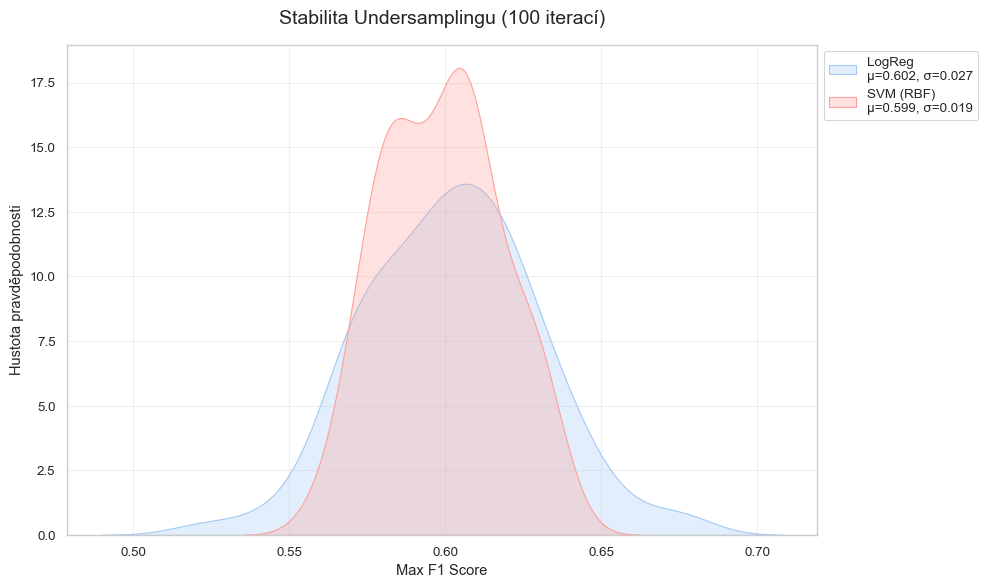


📊 STATISTICKÉ VÝSLEDKY:
🔹 LogReg: Mean=0.6021 | Std=0.0274 | 95% CI: [0.5526, 0.6549]
🔹 SVM (RBF): Mean=0.5991 | Std=0.0188 | 95% CI: [0.5672, 0.6337]


In [16]:
from collections import defaultdict
import time

# =============================================================================
# 7. S1c: BOOTSTRAP VALIDATION (STABILITY CHECK)
# =============================================================================
# Ověříme stabilitu modelu Baseline (Balanced) pomocí 100 náhodných undersamplingů.

# Konfigurace
N_BOOTSTRAPS = 100            # Pro rychlý test dej 10, pro finále 100
MODELS_TO_TEST = ["LogReg", "SVM (RBF)"] # Kandidáti
SCENARIO = 'baseline'         # Základní data

print(f"🔄 SPOUŠTÍM S1c BOOTSTRAPING ({N_BOOTSTRAPS} iterací)")
print(f"   Modely: {MODELS_TO_TEST}")
print("-" * 60)

bootstrap_scores = defaultdict(list)
start_global = time.time()

# 1. Načteme plná data (imbalanced) jen jednou
data_full = data_splitting.get_train_val_test_splits(
    scenario=SCENARIO, level='token', filter_type='aggressive', random_state=42
)
X_train_full, y_train_full = data_full['X_train'], data_full['y_train']
X_test_fixed, y_test_fixed = data_full['X_test'], data_full['y_test']

# Indexy pro undersampling
idx_l0 = np.where(y_train_full == 0)[0]
idx_l1 = np.where(y_train_full == 1)[0]
n_samples = len(idx_l1) # Chceme poměr 1:1

for i in tqdm(range(N_BOOTSTRAPS), desc="Bootstrapping"):
    
    # 2. Náhodný Undersampling (s měnícím se seedem 'i')
    np.random.seed(i)
    idx_l0_down = np.random.choice(idx_l0, size=n_samples, replace=False)
    idx_balanced = np.concatenate([idx_l0_down, idx_l1])
    np.random.shuffle(idx_balanced)
    
    # Nová trénovací sada pro tuto iteraci
    X_train_iter = X_train_full[idx_balanced]
    y_train_iter = y_train_full[idx_balanced]
    
    for model_name in MODELS_TO_TEST:
        try:
            # 3. Inicializace a trénink
            # random_state fixujeme (42), abychom měřili vliv DAT, ne vliv inicializace vah
            clf = models.get_supervised_model(model_name, random_state=42)
            clf.fit(X_train_iter, y_train_iter)
            
            # 4. Predikce na fixním test setu
            if hasattr(clf, "predict_proba"):
                y_probs = clf.predict_proba(X_test_fixed)[:, 1]
            else:
                y_probs = clf.decision_function(X_test_fixed)
            
            # 5. Výpočet Max F1 (Najdeme optimální práh pro tuto iteraci)
            # Použijeme tvou novou funkci z evaluation
            # Pozn: Threshold hledáme na TESTU jen pro účely bootstrapu (upper bound performance)
            # Správně by se měl hledat na VAL, ale pro stabilitu je toto akceptovatelné zjednodušení.
            _, f1_score = evaluation.find_optimal_threshold(y_test_fixed, y_probs, metric='f1')
            
            bootstrap_scores[model_name].append(f1_score)
            
        except Exception as e:
            print(f"❌ Chyba u {model_name} v iteraci {i}: {e}")

print(f"✅ Hotovo za {time.time() - start_global:.1f} sekund.")

# 6. Vizualizace
visualization.plot_bootstrap_results(
    bootstrap_scores, 
    metric_name="Max F1 Score", 
    title=f"Stabilita Undersamplingu ({N_BOOTSTRAPS} iterací)",
    save_path=config.RESULTS_DIR / "M2_S1c_Bootstrap_Stability.png"
)